In [ ]:
sudo apt-get install trash-cli
trash-empty
cd /mnt/tempvol/home/ubuntu/Desktop/Ctdata

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import matplotlib.pyplot as plt
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
import pydicom
import re
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


def chunks(l, n):
    count = 0
    for i in range(0, len(l), n):
        if (count < NoSlices):
            yield l[i:i + n]
            count = count + 1


def mean(l):
    return sum(l) / len(l)
def normalize2(image):
    mean = image.mean()
    if mean >0:
        MIN_BOUND = 0
        MAX_BOUND = 1024
    else:
        MIN_BOUND = -1024
        MAX_BOUND = 0
        
    image[image == -2000] = 0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    
    image[image>1] = 1.
    image[image<0] = 0.
    return image
def get_segmented_lungs(im, plot=False):

    binary = im < -400

    cleared = clear_border(binary)

    label_image = label(cleared)

    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0

    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)

    get_high_vals = binary == 0
    im[get_high_vals] = 0

        
    return im

In [ ]:
eben0=os.listdir(r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/0/")
eben1=os.listdir(r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/1/")
eben2=os.listdir(r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/2/")
eben3=os.listdir(r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/3/")

In [ ]:
ct0=[]
ct1=[]
ct2=[]
ct3=[]

In [ ]:
def unlabeledProcessing(patient, size,noslices):
        path = dataDirectory + patient + "/stu01" + "/ser01"
        if 'stu02' in os.listdir(dataDirectory + patient):
            path=dataDirectory + patient + "/stu02" + "/ser01"
        data4 = os.listdir(path)
        data4.sort()
        data5 = data4
        minv=round(len(data5)/4)
        maxv=round(len(data5)/1.7)
        if len(data5)<113:
            maxv=round(len(data5)/1.29)
        if len(data5)<50:
            minv=0
            maxv=round(len(data5)/1)
        data5=data5[minv:maxv]
        slices = [pydicom.read_file(path + '/' + s) for s in data5]
        #slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))
        slices = get_pixels_hu(slices)

        new_slices = []
        slices = [normalize2(get_segmented_lungs(cv2.resize(np.array(each_slice), (size, size)))) for each_slice in slices]

        chunk_sizes = math.floor(len(slices) / noslices)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)
        if not new_slices:
            print("Could not create test set")
        else:
            var.append(np.array(new_slices))

In [ ]:
NoSlices=25
#dataDirectory = r"/home/ubuntu/ctdata/3/"
#lungPatients = os.listdir(dataDirectory)
for i in range(4):
    if i ==0:
        var = ct0
        dataDirectory=r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/0/"
        lungPatients = eben0
    if i ==1:
        var = ct1
        dataDirectory=r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/1/"
        lungPatients = eben1
    if i ==2:
        var = ct2
        dataDirectory=r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/2/"
        lungPatients = eben2
    if i ==3:
        var = ct3
        dataDirectory=r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/3/"
        lungPatients = eben3
    print(i)
    for  patient in lungPatients:
        unlabeledProcessing(patient, size=144, noslices=25)

In [ ]:
dataDirectory=r"/mnt/tempvol/home/ubuntu/ctdata/0/"
lungPatients = eben0
for  patient in lungPatients:
        unlabeledProcessing(patient, size=180, noslices=25)

In [ ]:
ct0 = np.array(ct0)
ct1 = np.array(ct1)
ct2 = np.array(ct2)
ct3 = np.array(ct3)

In [ ]:
a[0:5]

In [ ]:
ct0.shape

In [ ]:
ct0[0].shape

In [ ]:
plt.imshow(ct1[4][18],cmap="gray")

In [ ]:
#np.save('CTSEG192-40.npy',data)
np.save('ct0.npy',ct0)
np.save('ct1.npy',ct1)
np.save('ct2.npy',ct2)
np.save('ct3.npy',ct3)


In [3]:
ct0 = np.load("ct0.npy",allow_pickle=True)
ct1 = np.load("ct1.npy",allow_pickle=True)
ct2 = np.load("ct2.npy",allow_pickle=True)
ct3 = np.load("ct3.npy",allow_pickle=True)

In [ ]:
cd /home/ubuntu/Notebooks

In [ ]:
data = np.load("CTSEG192-40.npy",allow_pickle=True)
#data = np.load("CTSEG180-25.npy",allow_pickle=True)


In [ ]:
X_test=np.load("test.npy",allow_pickle=True)

In [4]:
y_ml=[]

In [ ]:
ct3.shape[0]

In [5]:
for i in range(ct0.shape[0]):
    y_ml.append(0)

for i in range(ct1.shape[0]):
    y_ml.append(1)

for i in range(ct2.shape[0]):
    y_ml.append(1)

for i in range(ct3.shape[0]):
    y_ml.append(1)

In [6]:
from keras.utils.np_utils import to_categorical
y_ml= to_categorical(y_ml)

Using TensorFlow backend.


In [ ]:
y= to_categorical(y)

In [ ]:
ct0=data[:122]#122
ct1=data[122:211]
ct2=data[211:277]
ct3=data[277:295]

In [ ]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate)

In [ ]:


zenci = Compose([ShiftScaleRotate(rotate_limit=17,scale_limit=0.07,p=0.85,shift_limit=0.0500),
    HorizontalFlip(p=0.85)],additional_targets={'image00': 'image', 'image01': 'image',"image02":"image","image03":"image","image04":"image","image05":"image","image06":"image","image07":"image","image08":"image","image9":"image","image10":"image","image11":"image","image12":"image","image13":"image","image14":"image","image15":"image","image16":"image","image17":"image","image18":"image","image19":"image","image20":"image","image21":"image","image22":"image","image23":"image"})

In [ ]:
plt.imshow(ct3[1][20],cmap="gray")

In [ ]:
plt.imshow(z1[1][20],cmap="gray")

In [ ]:
z1=[]
for j in range(len(ct1)):
    for i in range(25):
            if i==0:
                globals()["image"] = ct3[j][i]
            if i>9:
                globals()["image" + str(i-1)] = ct3[j][i]
            else:
                globals()["image0" + str(i-1)] = ct3[j][i]
                
    transformed = zenci(image=image, image00=image00, image01=image01,image02=image02,image03=image03,image04=image04,image05=image05,image06=image06,image07=image07,image08=image08,image9=image9,image10=image10,image11=image11,image12=image12,image13=image13,image14=image14,image15=image15,image16=image16,image17=image17,image18=image18,image19=image19,image20=image20,image21=image21,image22=image22,image23=image23)
    z1.append(list(transformed.values()))
z1 = np.array(z1)

In [ ]:
ct1 = np.concatenate([ct1,z1])

In [ ]:
ct2.shape

In [ ]:
plt.imshow(ct0[127][19],cmap="gray")

In [ ]:
plt.imshow(ct2[110][10],cmap="gray")

In [ ]:
ct11= np.concatenate([ct1,ct2,ct3])

In [ ]:
ct11= np.concatenate([ct1[:100],ct2[:110],ct3[:40]])

In [ ]:
X = np.concatenate([ct0,ct11])

In [7]:
X= np.concatenate([ct0,ct1,ct2,ct3])

In [8]:
X.shape

(405, 40, 144, 144)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_ml, test_size=0.2, random_state=42)

In [ ]:
X_train= X_train.reshape(X_train.shape[0], 25,144,144,1) #reshaping
X_test = X_test.reshape(X_test.shape[0], 25,144,144,1) # reshaping also for adding color dimension 1 for grayscale

In [10]:
X_train= X_train.reshape(X_train.shape[0], 40,144,144,1) 
X_test = X_test.reshape(X_test.shape[0], 40,144,144,1) 

In [11]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization,Activation
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Model,Sequential

In [12]:
model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), input_shape=(40,144,144,1),activation="relu"))
model.add(MaxPool3D(pool_size=(2, 2, 2),strides=(2,2,2),padding='same'))
model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPool3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.00001), metrics=['acc'])
model.fit(X_train,y_train, batch_size=4,epochs=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





324/324 [==============================] - 64s 199ms/step - loss: 0.8893 - acc: 0.5216


In [ ]:
model.save('covidctMLBig_model.h5',include_optimizer=False)

In [ ]:
from keras.models import load_model
model = load_model('covidctMLBig_model.h5')

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.0001), metrics=['acc'])
model.fit(X_train,y_train, batch_size=8,epochs=145)

In [ ]:
X_test.shape

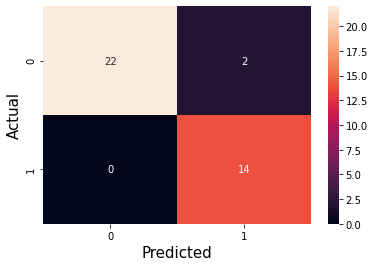

In [47]:
heatmap = [[22,2],
          [0,14]]

sn.heatmap(heatmap, annot=True)


plt.ylabel('Actual', fontsize = 15) # x-axis label with fontsize 15
plt.xlabel('Predicted', fontsize = 15) # y-axis label with fontsize 1
plt.show()

In [21]:
y_test.argmax(axis=1)

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

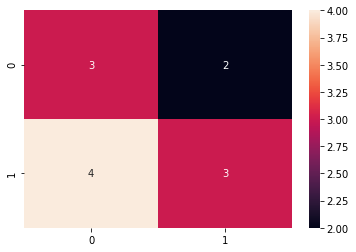

In [43]:
import pandas as pd
import seaborn as sn

preds = model.predict(X_test,batch_size=10)
confusion_matrix = pd.crosstab(y_test.argmax(axis=1),preds.argmax(axis=1), rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(heatmap, annot=True)

In [ ]:
len(X_test)

In [ ]:

matrix = confusion_matrix(y_test.argmax(axis=1),preds.argmax(axis=1))

In [ ]:
import os
dataDirectory = r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/2/nisanpat005/"
lungPatients = os.listdir(dataDirectory)
lungPatients[28]

In [ ]:
predzz=[]
ct1t = ct2.reshape(ct2.shape[0],40,144,144,1)
for i in ct1t:
    predzz.append(model.predict(np.expand_dims(i, axis=0)).argmax(axis=1))

In [ ]:
indices = [i for i, x in enumerate(predzz) if x == [[0]]]
indices

In [ ]:
plt.imshow(X_test[84][20],cmap="gray")

In [ ]:
plt.imshow(X_test[84][20],cmap="gray")

In [ ]:
b = []
for i in range(21):
    test1 =np.expand_dims(testData[i], axis=0)
    pred = model.predict(test1)
    indices = np.where(pred[0] == pred[0].max())
    if indices[0][0]==0:
        b.append(0)
    if indices[0][0]==1:
        b.append(1)
    

In [ ]:
pred = model.predict(test1)
indices = np.where(pred[0] == pred[0].max())
if indices[0][0]==0:
    print("Negative")
if indices[0][0]==1:
    print("Positive")
pred

In [ ]:
import scipy
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
first_patient = load_scan(r"/mnt/tempvol/home/ubuntu/Desktop/Ctdata/2/nisanpat013/stu01/ser01/")
first_patient_pixels = get_pixels_hu(first_patient)

In [ ]:
pix_resampled= resample(first_patient_pixels, first_patient, [1,1,1])

In [ ]:
pix_resampled = np.array(pix_resampled)

In [ ]:
model.save('covidctML55_model.h5',include_optimizer=False)

In [ ]:
pix_resampled[0].shape

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Dense,Conv3D,Flatten,add
from keras.layers import AvgPool2D,AvgPool3D,GlobalAveragePooling2D,GlobalAveragePooling3D, MaxPool2D,MaxPool3D
from keras.models import Model
from keras.layers import ReLU, concatenate
import keras.backend as K


In [ ]:
visible = Input(shape=(25,180,180,1))
x = Conv3D(64, kernel_size=(5,7,7))(visible)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool3D()(x)


#first resblock
shortcut = x
shortcut = Conv3D(64, kernel_size=(1,3,3), strides=(1,1,1), padding='same')(shortcut)
shortcut = BatchNormalization()(shortcut)
shortcut = ReLU()(shortcut)
x = add([shortcut, x])

x = MaxPool3D()(x)


#second resblock
shortcut = x
shortcut = Conv3D(64, kernel_size=(1,3,3), strides=(1,1,1), padding='same')(shortcut)
shortcut = BatchNormalization()(shortcut)
shortcut = ReLU()(shortcut)
x = add([shortcut, x])
x = Dropout(0.5)(x)
x = Conv3D(32, kernel_size=(3,3,3),padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)





x = Flatten()(x)

output = Dense(2, activation='sigmoid')(x)
model = Model(inputs=visible, outputs=output)

In [ ]:
model.summary()

In [ ]:
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 224, 224, 3
n_classes = 3
model = densenet(input_shape,n_classes)
model.summary()